# Equality-constrained analytic centering + нижняя граница $x ≥ 1$ и логарифмическим барьером

<i>minimize</i> $f(x)=-\sum_{i=1}^{n}log(x_i)$ <br>
<i>subject to</i> $Ax=b$ <br>
<i>additional constraints:</i> $x\geq{1}$, $i = 1,..., n.$ <br>

<br>

• $A ∈ R^{p×n}$, $rankA = p < n$.<br>
• Равенство определяет **аффинное** (выпуклое) множество.<br>
• Неравенства $x_i ≥ 1$ задают $m = n$ ограничений.<br>

<hr>

Для каждого ограничения вводим: <br>
$f_i(x)=1-x_i\leq{0}$, $i = 1,...n$. <br><br>
Логарифмический барьер (при фиксированном $t > 0$):<br>
$\phi(x)=-\frac{1}{t}\sum_{i=1}^{m}log(-f_i(x))=-\frac{1}{t}\sum_{i=1}^{m}log(x_i-1)$<br><br>

Допустимая область: $D=\{x|Ax=b,x_i>1, ∀i\}$.

**Новая задача**:
<i>minimize</i> $f_b(x)=-\sum_{i=1}^{n}log(x_i)-\frac{1}{t}\sum_{i=1}^{m}log(x_i-1)$ <br>
<i>subject to</i> $Ax=b$ <br>

<hr>

Приближённая (барьерная) задача: <br>
<i>minimize</i> $F_t(x)= t f_0(x) + ϕ_t(x)$ <br>
<i>subject to</i> $Ax=b$ <br>

<br>

Градиент и гессиан $F_t$:<br>
$∇F_t(x) = -t[1/x_1,…,1/x_n​]^T - [1/(x_1 - 1),…,1/(x_n−1)]^T,$<br>
$∇F_t(x) = diag(\frac{t}{x_i^2} + \frac{1}{(x_i - 1)^2}) ≻ 0\$<br><br>

Диагональный гессиан **положительно определён** во всей области $D$. Значит $F_t$ **строго выпукла**.

<hr>

Выпуклость всей задачи: <br>
1. Целевая функция $F_t$ — строго выпукла (строгое ≻ 0 гессиана).
2. Множество ограничений $Ax=b$ — аффинное → выпуклое.

Следовательно барьерная задача при любом фиксированном $t > 0$ - **строго выпуклая**. Решение существует (если исходная задача строго допустима) и **единственно**.

$f(x)$ и $\phi(x)$ являются выпуклыми как суммы выпуклых функций, аналогично $f_b(x) = f(x)+\phi(x)$ является выпуклой при фиксированном $t>0$. Ограничение $Ax=b$ задаёт аффинное множество, которое всегда является выпуклым. Таким образом, задача является **выпуклой**.

<hr>

## Для каждого значения размерности $n ∈ {10,20,...,100}$ сгенерируйте $N = 100$ тестовых примеров В каждом случае найдите глобальный минимум, $x^* ∈ R^n$, с помощью CVX

In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import time
from scipy.linalg import null_space
import pickle
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
rseed = 45
np.random.seed(rseed)

def generate_problem(n, seed=None):
    """
    Генерирует задачу для оптимизации.

    Параметры:
    ----------
    n: Размерность искомого вектора x ∈ ℝⁿ.
    seed: Значение для инициализации генератора случайных чисел (для воспроизводимости).

    Возвращает:
    -----------
    A: Матрица ограничений, с m = floor(n / 5) строк.
    b: Вектор правой части, вычисленный как b = A @ x_true.
    x_true: Генерируемая допустимая точка (гарантированно положительная).
    """

    rng = np.random.default_rng(seed)

    """
    Размерность m выбирается как n // 5, чтобы гарантировать наличие ненулевого ядра у A (m < n),
    что важно при генерации допустимых начальных точек через сдвиг вдоль ядра A.
    """
    m = n // 5
    A = rng.uniform(0, 100, size=(m, n))  # случайная матрица A ∈ ℝ^(m×n)

    x_true = rng.uniform(1.1, 50.0, size=n)  # гарантированно x_i > 1
    b = A @ x_true  # правая часть системы Ax = b

    return A, b, x_true


def solve_problem(A, b):
    """
    Решает задачу выпуклой оптимизации.

    Параметры:
    ----------
    A: Матрица линейных ограничений.
    b: Правая часть системы ограничений A x = b.

    Возвращает:
    -----------
    x_opt: Оптимальное решение x*, если найдено. Иначе — None.
    f_opt: Оптимальное значение целевой функции f(x*) = -∑ log(x_i). Иначе — None
    """

    n = A.shape[1]
    x = cp.Variable(n)

    # Целевая функция: максимизировать сумму логарифмов
    objective = cp.Minimize(-cp.sum(cp.log(x)))

    # Ограничения: линейная система A x = b
    constraints = [A @ x == b, x >= 1]

    # Определяем и решаем задачу
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Обработка случая, если задача не имеет допустимого решения
    if prob.status in ["infeasible", "unbounded", "solver_error", "unbounded_inaccurate", "infeasible_inaccurate"]:
        return None, None

    return x.value, prob.value

In [3]:
# Размерности задач
dimensions = range(10, 101, 10)

# Число задач на каждую размерность
N = 100

a_generated = {n_val:[] for n_val in dimensions} # Список матриц A для каждой размерности
b_generated = {n_val:[] for n_val in dimensions} # Список векторов b
x_true_generated = {n_val:[] for n_val in dimensions} # Истинные допустимые решения (для генерации b)
cvx_opts = {n_val:[] for n_val in dimensions} # Оптимальные значения f(x*) через CVXPY
cvx_time = {n_val:[] for n_val in dimensions}  # Время решения каждой задачи

for n in dimensions:
    for _ in tqdm(range(N), desc=f"Processing N = {n}"):
        # 1. Генерация задачи: A, b, x_true (гарантированно x_true > 0, b = A @ x_true)
        A, b, x_true = generate_problem(n)

        # 2. Решение через CVXPY + замер времени
        start_time = time.time()
        x_star, min_value = solve_problem(A, b)
        elapsed_time = time.time() - start_time

        # 3. Проверка на корректность решения
        if x_star is None:
            print("The problem is infeasible or unbounded.")
            continue

        # 4. Сохраняем результаты
        a_generated[n].append(A)
        b_generated[n].append(b)
        x_true_generated[n].append(x_true)
        cvx_opts[n].append(min_value)
        cvx_time[n].append(elapsed_time)

print("\nDone")

Processing N = 100: 100%|██████████| 100/100 [00:01<00:00, 74.86it/s]


Done


# Для каждого значения $n ∈ {10,20,...,100}$ и для каждого тестового примера сгенерируйте 100 начальных точек. Для заданной точности по значению функции $ε = 0.01$ решите задачу с помощью метода логарифмических барьеров для различных значений параметра $µ ∈ {2,10,50,100}$ и $t_0 = 1$. Приведите необходимые аналитические вычисления.

Для решения подзадачи в методе барьеров мы используем метода Ньютона с максимальным количеством итераций 50.

In [4]:
def primal_obj(x):
  """
  Целевая функция f(x) = -∑ log(x_i).
  Предполагается, что все компоненты x_i > 0.
  """
  return -np.sum(np.log(x))

def barrier_obj(x, t):
  """
  Вычисляет барьерную функцию:
      F_t(x) = t * f(x) + φ(x)
              = -∑ log(x_i) - (1/t) ∑ log(x_i - 1)
  """
  return -np.sum(np.log(x)) - (1/t) * np.sum(np.log(x - 1))

def barrier_grad(x, t):
  """
  Градиент барьерной функции F_t(x):
      ∇F_t(x) = -1 / x - (1 / t) * 1 / (x - 1)
  """
  return -1 / x - 1.0 / (x - 1) * (1/t)

def barrier_hess(x, t):
  """
  Гессиан (вторая производная) барьерной функции F_t(x), возвращает диагональную матрицу:
      H = diag(1 / x_i^2 + (1 / t) * 1 / (x_i - 1)^2)
  """
  return np.diag(1 / x**2 + 1.0 / (x - 1)**2 * (1/t))

In [5]:
def generate_newton_starts(A: np.ndarray,
                           x_true: np.ndarray,
                           num_starts: int = 5,
                           alpha_max: float = 30,
                           seed: int = None) -> np.ndarray:
    """
    Генерирует num_starts допустимых начальных точек x₀, таких что Ax = b и x > 1.
    Построение: x₀ = x_feas + α·k, где k — случайный вектор из ker(A),
    α — случайный коэффициент из [0, alpha_max].
    """
    rng = np.random.default_rng(seed)

    # Находим базис ядра матрицы A (размерность r = n - rank(A))
    U = null_space(A)  # U.shape = (n, r)
    if U.shape[1] == 0:
        raise ValueError("У матрицы A нет ненулевого ядра. Требуется m < n.")

    starts = []

    while len(starts) < num_starts:
        # Выбираем случайный вектор из базиса ядра
        j = rng.integers(U.shape[1])
        k = U[:, j]  # k ∈ ker(A)

        # Случайное масштабирование вдоль направления ядра
        alpha = rng.uniform(0, alpha_max)

        # Сдвигаем x_true вдоль направления ядра
        x_candidate = x_true + alpha * k

        # Проверка: все компоненты должны остаться положительными
        if np.all(x_candidate > 1):
            starts.append(x_candidate)

    return np.array(starts)

In [6]:
def solve_newton(x_init, A, b, f_opt, t=1, max_iters=1000, eps=1e-2, return_history=False):
    """
    Прямой метод Ньютона для минимизации барьерной функции F_t(x) при фиксированном t.
    Решает задачу:
        minimize   F_t(x)
        subject to A x = b,   x > 1

    Начальная точка x_init должна быть допустимой: A x_init = b, x_init > 1.

    Параметры:
    -----------
    x_init : np.ndarray
        Допустимая стартовая точка.
    A, b : np.ndarray
        Матрица и правая часть линейного ограничения A x = b.
    f_opt : float
        Оптимальное значение исходной функции f₀(x), используется для оценки точности.
    t : float
        Параметр барьера (чем больше t, тем жёстче приближение к исходной задаче).
    max_iters : int
        Максимальное число итераций Ньютона.
    eps : float
        Точность по цели: остановка при |f₀(x) - f₀(x*)| < eps.
    return_history : bool
        Если True, возвращается история ошибок по f₀(x) на каждой итерации.

    Возвращает:
    -----------
    x : np.ndarray
        Найденное решение.
    f_val : float
        Значение f₀(x) на найденной точке.
    err : float
        Абсолютная ошибка |f₀(x) - f₀(x*)|.
    iters : int
        Число выполненных итераций Ньютона.
    history : List[float], optional
        История ошибок |f₀(x_k) - f₀(x*)| по итерациям (если return_history=True).
    """

    # Делаем копию x_init
    x = x_init.copy()

    # Определяем размерность
    n, m = x.size, A.shape[0]

    # Начальное значение ошибки
    prec_history = []
    current_err = abs(primal_obj(x) - f_opt)
    prec_history.append(current_err)

    # Параметры для backtracking line search (из книги)
    alpha = 0.1
    beta = 0.5

    for k in range(max_iters):
        # 1) Вычисляем градиент и гессиан
        grad = barrier_grad(x, t)
        hess = barrier_hess(x, t)

        # 2) Формируем KKT-систему
        KKT = np.block([
            [hess, A.T],
            [A,    np.zeros((m, m))]
        ])
        rhs = np.hstack([-grad, np.zeros(m)])

        # 3) Решаем KKT
        sol = np.linalg.solve(KKT, rhs)
        dx = sol[:n]

        # 4) Backtracking line search
        f_val = barrier_obj(x, t)
        gdx = grad @ dx # скалярное произведение grad(x) · dx

        s = 1.0                 # шаг вдоль Δx
        success = False
        for _ in range(20):
            x_new = x + s * dx

            # Проверяем, что остаёмся в области x > 0
            if np.all(x_new > 1):
                f_new = barrier_obj(x_new, t)
                if f_new <= f_val + alpha * s * gdx:
                    success = True
                    break
            s *= beta

        # Если ни один шаг не подошёл — останавливаемся
        if not success:
            break

        # Обновляем x
        x = x_new

        # 5) Считаем новую ошибку
        current_err = abs(primal_obj(x) - f_opt)
        if return_history:
            prec_history.append(current_err)

        # 6) Проверяем достижение требуемой точности
        dec = 0.5 * dx @ (hess @ dx)

        if dec < 1e-6:
            break

    if return_history:
        return x, primal_obj(x), current_err, k + 1, prec_history
    else:
        return x, primal_obj(x), current_err, k + 1

In [7]:
def barrier_method(x_init, A, b, f_opt, mu, t0=1, eps=1e-2, max_inner_iters=50, return_history=False):
    """
    Метод логарифмических барьеров для задачи выпуклой оптимизации:
        minimize   f₀(x) = -∑ log(x_i)
        subject to Ax = b,   x_i ≥ 1

    Функция решает серию барьерных подзадач:
        F_t(x) = t·f₀(x) + φ(x),   где φ(x) = -∑ log(x_i - 1),
    постепенно увеличивая t → ∞, чтобы приблизиться к решению исходной задачи.

    Алгоритм:
    ----------
    1. Инициализируем параметр барьера t = t₀.
    2. Пока дуальный разрыв m/t > ε и KKT-норма > 1e-3:
       - решаем подзадачу для F_t(x) методом Ньютона (внутренний цикл),
       - оцениваем дуальный разрыв: m / t,
       - вычисляем норму KKT-остатка ∥∇F_t(x) - Aᵀν, Ax - b∥₂,
       - увеличиваем t ← µ·t.
    3. Выход по достижении нужной точности: duality gap, KKT и err < ε.

    Параметры:
    -----------
    x_init : np.ndarray
        Начальная допустимая точка: Ax = b и x > 1.
    A, b : np.ndarray
        Ограничения линейной равенства Ax = b.
    f_opt : float
        Известное оптимальное значение f₀(x*) — используется для контроля точности.
    mu : float
        Коэффициент роста параметра t (обычно µ ∈ {2, 10, 50, 100}).
    t0 : float
        Начальное значение параметра барьера t.
    eps : float
        Требуемая точность по f₀(x) и по дуальному разрыву.
    max_inner_iters : int
        Максимальное число итераций метода Ньютона на одну подзадачу.
    return_history : bool
        Если True, дополнительно возвращает историю ошибок, duality gap и KKT-норм.

    Возвращает:
    -----------
    x : np.ndarray
        Найденное решение.
    f_val : float
        Значение f₀(x) на найденной точке.
    err : float
        Абсолютная ошибка |f₀(x) - f₀(x*)|.
    barrier_iters : int
        Число итераций внешнего (барьерного) цикла.
    history : List[float], optional
        История ошибок по f₀(x) (если return_history=True).
    duality_gap_hist : List[float], optional
        История значений m / t по итерациям.
    kkt_hist : List[float], optional
        История норм KKT-остатка ∥r(x, ν)∥₂.
    """

    x = x_init.copy() # Делаем копию стартовой точки x0 (допустимая: A x = b, x > 1)
    t = float(t0) # Начальное значение параметра барьера t

    # Инициализация логов: история ошибки, дуального разрыва и KKT-норм
    history = []
    duality_gap_hist = []
    kkt_hist         = []

    m_in = x.size # Число неравенственных ограничений

    barrier_iters = 0
    while True:
        barrier_iters += 1

        # === Решаем подзадачу методом Ньютона при фиксированном t ===
        x, f_val, err, iters = solve_newton(x, A, b, f_opt, t, max_iters=max_inner_iters)

        # === Вычисляем KKT-остаток ===
        try:
          grad_Ft = -t / x - 1.0 / (x - 1)
        except OverflowError:
          # Если t стал слишком большим (float → int), выходим
          print("OverflowError caught: t - too large.")
          break

        # Решаем A Aᵀ ν = A ∇F_t(x), получаем вектор множителей Лагранжа ν
        nu = np.linalg.solve(A @ A.T, A @ grad_Ft)

        # Остаток по условиям KKT:
        # r₁ = ∇F_t(x) - Aᵀ ν,  r₂ = A x - b
        r_1 = grad_Ft - A.T @ nu
        r_2 = A @ x - b

        # Считаем норму ||r||₂ = sqrt(||r₁||² + ||r₂||²)
        kkt_norm = np.linalg.norm(np.hstack([r_1, r_2]), 2)
        kkt_hist.append(kkt_norm)

        # === Вычисляем дуальный разрыв ===
        gap = m_in / t
        duality_gap_hist.append(gap)

        history.append(err)

        # === Условие останова ===
        if len(history) > 1 and err < eps and gap <= eps: #and kkt_norm <= 1e-5: #: #
            break

        # === Усиливаем барьер ===
        t *= mu

    # === Возвращаем результаты ===
    if return_history:
        return (x, f_val, err, barrier_iters,
                history, duality_gap_hist, kkt_hist)

    return x, f_val, err, barrier_iters

In [8]:
# Загрузка ранее расчитанных данных
if os.path.exists('data/lab4/data.pkl'):
    with open('data/lab4/data.pkl', 'rb') as fin:
        lab4_data = pickle.load(fin)
    mu_barrier_opts = lab4_data['mu_barrier_opts']
    mu_barrier_eps = lab4_data['mu_barrier_eps']
    mu_barrier_time = lab4_data['mu_barrier_time']
    mu_barrier_iters = lab4_data['mu_barrier_iters']

In [9]:
mu_list = [2, 10, 50, 100]

mu_barrier_opts = {}
mu_barrier_eps = {}
mu_barrier_time = {}
mu_barrier_iters = {}

for mu in mu_list:
    print('----------------')
    print(f'MU = {mu}')

    barrier_opts  = {n: [] for n in dimensions}  # Средние значения f(x*) для каждой размерности
    barrier_eps   = {n: [] for n in dimensions}  # Средние ошибки |f(x) - f_opt|
    barrier_time  = {n: [] for n in dimensions}  # Среднее время (сек) на одну точку
    barrier_iters = {n: [] for n in dimensions}  # Среднее число итераций
    data_for_graph = {}                         # Подробные результаты для анализа

    for n in dimensions:
        data_for_graph[n] = {}
        print(f"Processing n = {n}")

        for i in tqdm(range(N)):
            data_for_graph[n][i] = {}

            # --- Заранее сгенерированные данные ---
            A = a_generated[n][i]
            b = b_generated[n][i]
            x_true = x_true_generated[n][i]
            cvx_opt = cvx_opts[n][i]

            # --- Генерация N допустимых стартов x_init ---
            x_inits = generate_newton_starts(A, x_true, num_starts=N, alpha_max=1000, seed=rseed)

            num_iter = 0
            total_eps = 0
            total_min_value = 0

            # --- Запускаем метод Ньютона для каждого старта ---
            start_time = time.time()

            for idx, x in enumerate(x_inits):
                x_star, min_value, eps, iters = barrier_method(x, A, b, cvx_opt, mu=mu, t0=1)
                num_iter += iters
                total_eps += eps
                total_min_value += min_value

                data_for_graph[n][i][idx] = {
                    'iter': iters,
                    'eps': eps,
                    'min_value': min_value
                }

            elapsed_time = time.time() - start_time

            # --- Сохраняем среднюю статистику по задаче ---
            barrier_time[n].append(elapsed_time / N)
            barrier_iters[n].append(num_iter / N)
            barrier_eps[n].append(total_eps / N)
            barrier_opts[n].append(total_min_value / N)

    mu_barrier_opts[mu] = barrier_opts
    mu_barrier_eps[mu] = barrier_eps
    mu_barrier_time[mu] = barrier_time
    mu_barrier_iters[mu] = barrier_iters


----------------
MU = 2
Processing n = 10


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Processing n = 20


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Processing n = 30


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Processing n = 40


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Processing n = 50


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Processing n = 60


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Processing n = 70


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


Processing n = 80


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Processing n = 90


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Processing n = 100


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


----------------
MU = 10
Processing n = 10


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Processing n = 20


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Processing n = 30


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


Processing n = 40


100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


Processing n = 50


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Processing n = 60


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Processing n = 70


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Processing n = 80


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Processing n = 90


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Processing n = 100


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


----------------
MU = 50
Processing n = 10


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Processing n = 20


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Processing n = 30


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Processing n = 40


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Processing n = 50


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


Processing n = 60


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Processing n = 70


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Processing n = 80


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Processing n = 90


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Processing n = 100


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


----------------
MU = 100
Processing n = 10


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Processing n = 20


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Processing n = 30


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Processing n = 40


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Processing n = 50


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Processing n = 60


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


Processing n = 70


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Processing n = 80


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Processing n = 90


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Processing n = 100


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [10]:
# Сохраняем результаты вычислений
lab4_data = {
    'a_generated': a_generated,
    'b_generated': b_generated,
    'x_true_generated': x_true_generated,
    'cvx_opts': cvx_opts,
    'cvx_time': cvx_time,
    'mu_barrier_opts': mu_barrier_opts,
    'mu_barrier_eps': mu_barrier_eps,
    'mu_barrier_time': mu_barrier_time,
    'mu_barrier_iters': mu_barrier_iters
}

if os.path.exists("data/lab4"):
  with open('data/lab4/data.pkl', 'wb') as fout:
    pickle.dump(lab4_data, fout)

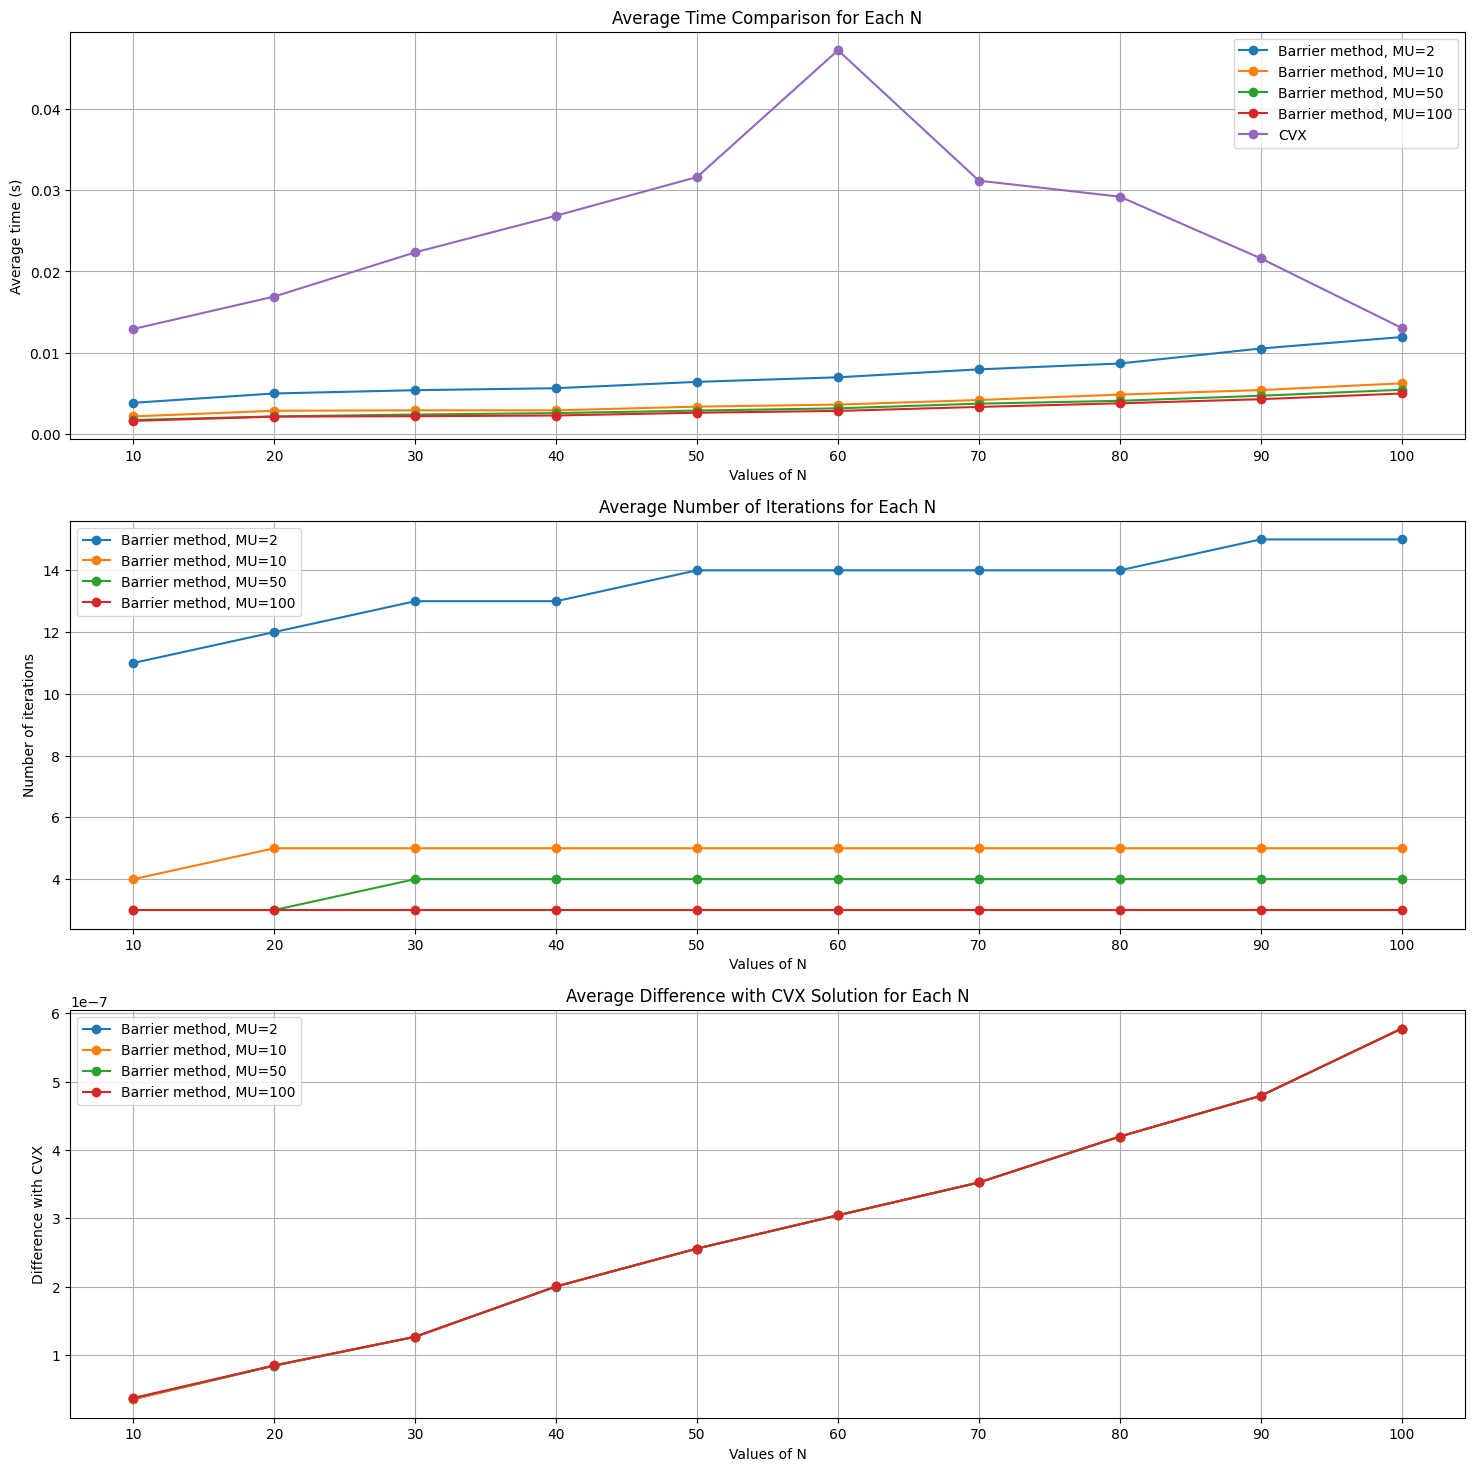

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(18, 18))
for mu in mu_list:
    axes[0].plot(dimensions, [sum(mu_barrier_time[mu][n])/len(mu_barrier_time[mu][n]) for n in dimensions], label=f'Barrier method, MU={mu}', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(cvx_time[n])/len(cvx_time[n]) for n in dimensions], label='CVX', marker='o', linestyle='-')
axes[0].set_xlabel('Values of N')
axes[0].set_ylabel('Average time (s)')
axes[0].set_title('Average Time Comparison for Each N')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(dimensions)

for mu in mu_list:
    axes[1].plot(dimensions, [sum(mu_barrier_iters[mu][n])/len(mu_barrier_iters[mu][n]) for n in dimensions], label=f'Barrier method, MU={mu}', marker='o', linestyle='-')
axes[1].set_xlabel('Values of N')
axes[1].set_ylabel('Number of iterations')
axes[1].set_title('Average Number of Iterations for Each N')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(dimensions)

for mu in mu_list:
    axes[2].plot(dimensions, [sum(mu_barrier_eps[mu][n])/len(mu_barrier_eps[mu][n]) for n in dimensions], label=f'Barrier method, MU={mu}', marker='o', linestyle='-')
axes[2].set_xlabel('Values of N')
axes[2].set_ylabel('Difference with CVX')
axes[2].set_title('Average Difference with CVX Solution for Each N')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(dimensions)

In [12]:
mu_list = [2, 10, 50, 100]

A, b, x_true = generate_problem(n=10)
cvx_x, cvx_opt = solve_problem(A, b)

x_inits = generate_newton_starts(A, x_true, num_starts=100, alpha_max=1000, seed=rseed)
histories = {}
dualities = {}
kkt_histories = {}

for mu in mu_list:
    histories[mu] = list()
    dualities[mu] = list()
    kkt_histories[mu] = list()

    for x_init in x_inits:
        x_star, min_value, eps, iters, history, duality_gap_hist, kkt_hist = barrier_method(x_init, A, b, cvx_opt, mu=mu, t0=1, return_history=True)

        histories[mu].append(history)
        dualities[mu].append(duality_gap_hist)
        kkt_histories[mu].append(kkt_hist)

In [13]:
mean_errs = {}

for mu in mu_list:
    cur_histories = histories[mu]
    max_len = max([len(history) for history in cur_histories])
    for i in range(len(cur_histories)):
        while len(cur_histories[i]) < max_len:
            cur_histories[i].append(cur_histories[i][-1])
    cur_histories = np.array(cur_histories)
    cur_mean_err = cur_histories.mean(axis=0)
    mean_errs[mu] = cur_mean_err

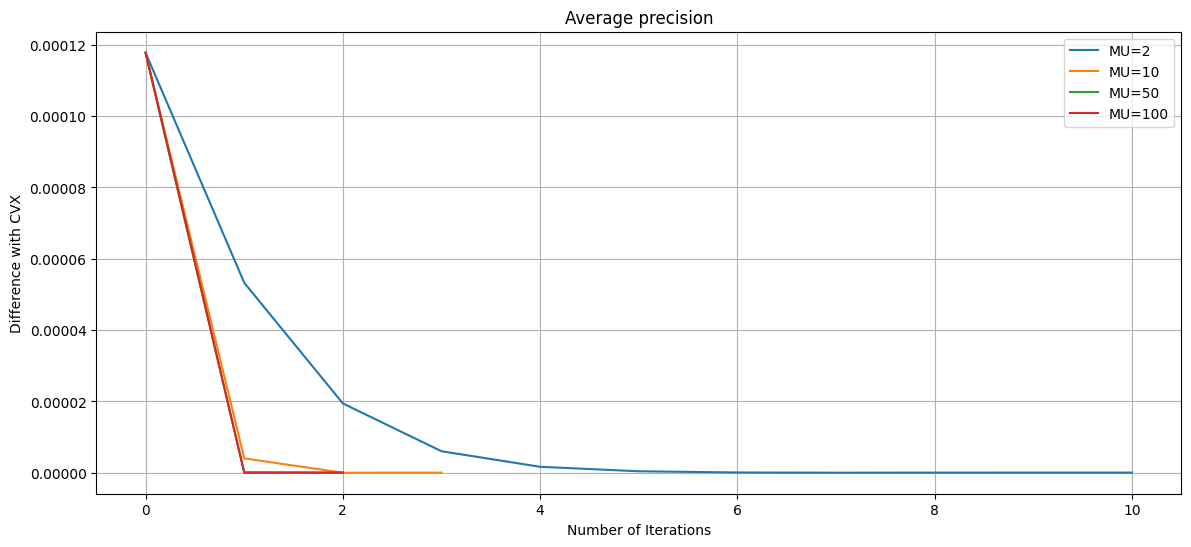

In [14]:
plt.figure(figsize=(14, 6))

for mu in mu_list:
    plt.plot(range(len(mean_errs[mu])), mean_errs[mu], label=f'MU={mu}')

plt.title('Average precision')
plt.xlabel('Number of Iterations')
plt.ylabel('Difference with CVX')
plt.legend()
plt.grid(True)


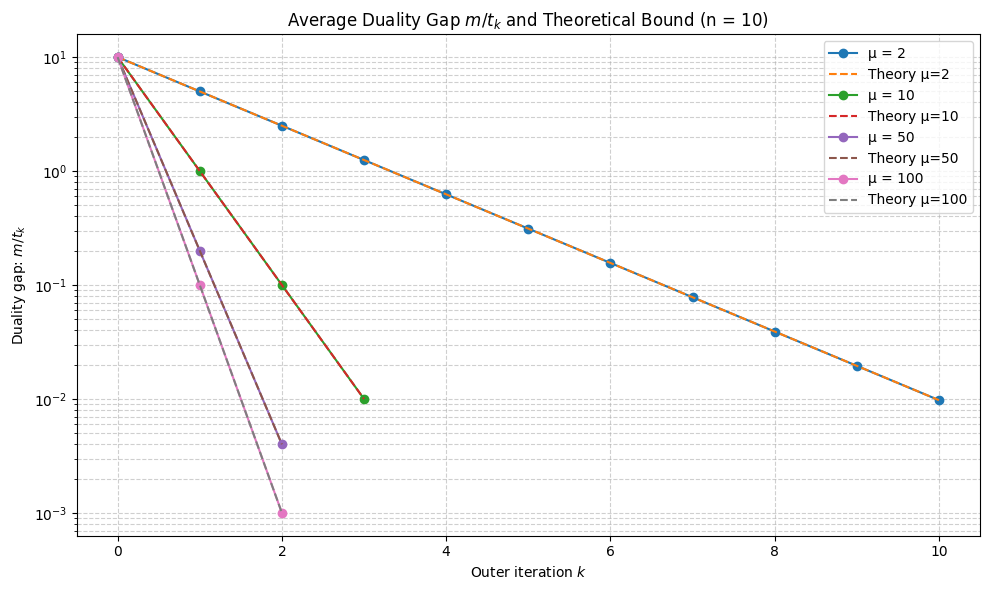

In [15]:
plt.figure(figsize=(10, 6))
t0 = 1
m = 10

for mu in mu_list:
    dlist = dualities[mu]
    maxlen = max(len(seq) for seq in dlist)

    padded = [seq + [seq[-1]] * (maxlen - len(seq)) for seq in dlist]
    avg_dual_gap = np.mean(padded, axis=0)

    plt.semilogy(avg_dual_gap, marker='o', label=f'μ = {mu}')

    k = np.arange(maxlen)
    theory = m / (t0 * mu ** k)
    plt.semilogy(k, theory, linestyle='--', label=f'Theory µ={mu}')

plt.title('Average Duality Gap $m / t_k$ and Theoretical Bound (n = 10)')
plt.xlabel('Outer iteration $k$')
plt.ylabel('Duality gap: $m / t_k$')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

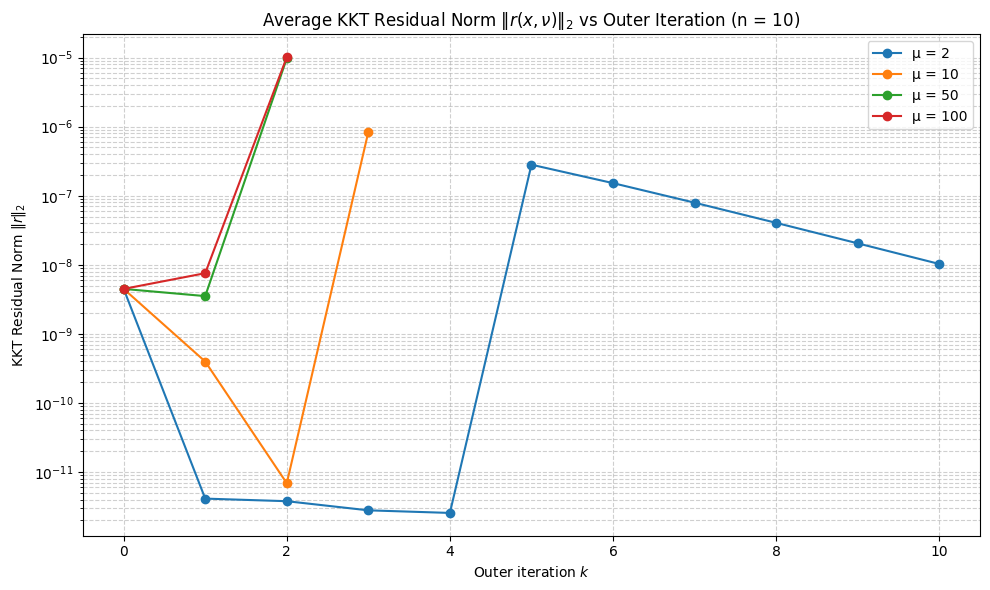

In [16]:
plt.figure(figsize=(10, 6))

for mu in mu_list:
    klist = kkt_histories[mu]
    maxlen = max(len(seq) for seq in klist)

    # выравниваем все истории по длине
    padded_kkt = [seq + [seq[-1]] * (maxlen - len(seq)) for seq in klist]
    avg_kkt_norm = np.mean(padded_kkt, axis=0)

    plt.semilogy(avg_kkt_norm, marker='o', label=f'µ = {mu}')

plt.title('Average KKT Residual Norm $\|r(x,\\nu)\|_2$ vs Outer Iteration (n = 10)')
plt.xlabel('Outer iteration $k$')
plt.ylabel('KKT Residual Norm $\|r\|_2$')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Теоретическая оценка из книги:

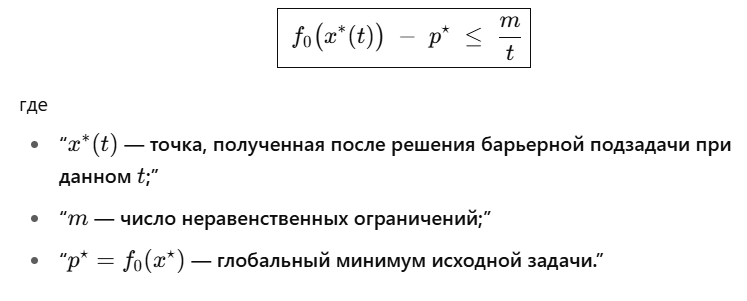

После каждой внешней итерации метода барьера мы умножаем $t$ на $μ$, поэтому оценка превращается в:

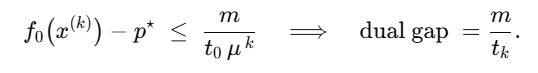

В коде:
- измеряем $|f_0(x) - p^⋆|$
- критерий $\frac{m}{t} ≤ ε$ обеспечивает $(|f_0(x)-p^⋆| ≤ ε)$

- KKT норма стабильно падает ниже $10^{−6}$
- duality gap — как $1/μ^k$